In [1]:
import numpy as np
import tbparse as tb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Table Results

In [2]:
#Extract tb logs
dfs = []
for dataset in ["ignition/", "neuron_transport/"]:#, "channel_flow"]:
    log_dir = "lightning_logs/"+dataset
    experiments = ["hnet_offline_full", "hnet_offline_subsample", "hnet_offline_fjlt", "hnet_online_subsample", "hnet_online_fjlt"]
    
    df = pd.DataFrame(columns=["metric"]+experiments)
    df["metric"] = ["Mean PSNR", "Std PSNR", "Mean RFE", "Std RFE"]
    
    for i, experiment in enumerate(experiments):
        reader = tb.SummaryReader(log_dir+experiment)
        df_ = reader.scalars
        df_ = df_[df_["tag"].isin(["real_test_avg_PSNR", "real_test_avg_RFError"])]
        
        df.loc[0,experiment] = np.mean(df_[df_["tag"] == "real_test_avg_PSNR"]["value"])
        df.loc[1,experiment] = np.std(df_[df_["tag"] == "real_test_avg_PSNR"]["value"])
        df.loc[2,experiment] = np.mean(df_[df_["tag"] == "real_test_avg_RFError"]["value"])*100
        df.loc[3,experiment] = np.std(df_[df_["tag"] == "real_test_avg_RFError"]["value"])*100

    dfs.append(df)

In [3]:
print("Ignition...")
dfs[0]

Ignition...


,metric,hnet_offline_full,hnet_offline_subsample,hnet_offline_fjlt,hnet_online_subsample,hnet_online_fjlt
0,Mean PSNR,41.601081,37.636314,37.055446,39.78086,40.380889
1,Std PSNR,0.624085,0.589397,0.919489,2.05585,3.770233
2,Mean RFE,2.173384,3.961669,3.866305,4.832455,8.979962
3,Std RFE,0.193465,0.315792,0.491862,2.658787,13.499667


In [41]:
print("Neuron Transport...")
dfs[1]

Neuron Transport...


,metric,hnet_offline_full,hnet_offline_subsample,hnet_offline_fjlt,hnet_online_subsample,hnet_online_fjlt
0,Mean PSNR,60.596428,37.247746,52.0872,45.612446,58.017242
1,Std PSNR,0.0,0.0,0.0,0.0,0.0
2,Mean RFE,0.562926,7.585403,1.445448,3.88189,0.835451
3,Std RFE,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Channel Flow...")
dfs[0]

# Neuron Transport: Performance v Sketch Size
Fixed compression rate with varying sketch sizes.

In [2]:
#Extract tb logs
log_dir = "lightning_logs/neuron_transport/"
experiments = [f"hnet_online_fjlt_%_{i}" for i in range(0,4)]
experiments.append("hnet_online_fjlt")

df = pd.DataFrame(columns=["Sample Factor", "RFE", "PSNR"])
sample_factors = np.linspace(0.001, 0.01, 5)

for i, experiment in enumerate(experiments):
    reader = tb.SummaryReader(log_dir+experiment)
    df_ = reader.scalars
    df_ = df_[df_["tag"].isin(["real_test_avg_PSNR", "real_test_avg_RFError"])]

    df.loc[i] = [sample_factors[i]*100, df_.loc[1,"value"]*100, df_.loc[0,"value"]]

In [3]:
df

,Sample Factor,RFE,PSNR
0,0.100,2.749467,51.839809
1,0.325,1.836249,54.551746
2,0.550,0.720277,58.845047
3,0.775,0.674789,58.665394
4,1.000,0.835451,58.017242


In [9]:
#Get offline baseline
df_ = tb.SummaryReader(log_dir+"hnet_offline_full").scalars
df_ = df_[df_["tag"].isin(["real_test_avg_PSNR", "real_test_avg_RFError"])]

df_offline = pd.DataFrame(columns=["RFE", "PSNR"])
df_offline.loc[0] = [df_.loc[1,"value"]*100, df_.loc[0,"value"]]

In [10]:
df_offline["RFE"][0]

0.5629261489957571

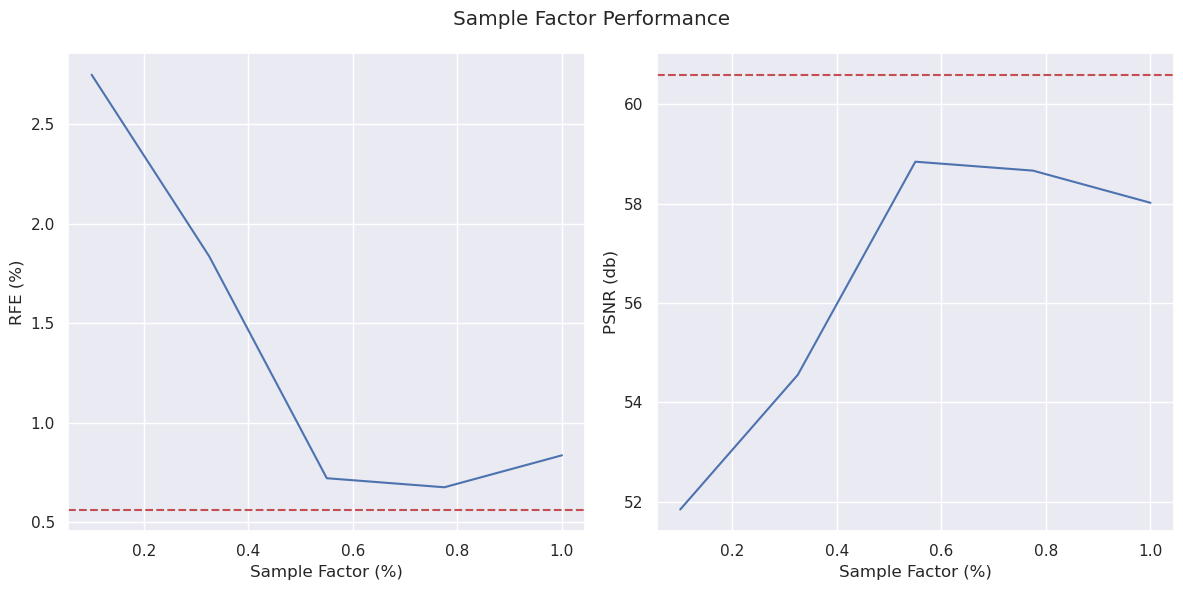

In [11]:
#Plot
fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.lineplot(data=df, x="Sample Factor", y="RFE", ax=ax[0])
ax[0].axhline(df_offline["RFE"][0], c="r", ls="--")
ax[0].set_xlabel("Sample Factor (%)")
ax[0].set_ylabel("RFE (%)")

sns.lineplot(data=df, x="Sample Factor", y="PSNR", ax=ax[1])
ax[1].axhline(df_offline["PSNR"][0], c="r", ls="--")
ax[1].set_xlabel("Sample Factor (%)")
ax[1].set_ylabel("PSNR (db)")

fig.suptitle("Sample Factor Performance")

fig.tight_layout()

In [12]:
fig.savefig("misc/figures/sample-factor-performance.png")

# Neuron Transport: Performance v Full Buffer Size
Fixed sketch size with varying full buffer sizes.

In [37]:
#Extract tb logs
log_dir = "lightning_logs/neuron_transport/"
experiments = ["hnet_online_fjlt"]
experiments.extend([f"hnet_online_fjlt_s_{i}" for i in range(0,-1,-1)])

df = pd.DataFrame(columns=["Full Buffer Size", "RFE", "PSNR"])
sizes = np.linspace(1, 25, 5)

for i, experiment in enumerate(experiments):
    reader = tb.SummaryReader(log_dir+experiment)
    df_ = reader.scalars
    df_ = df_[df_["tag"].isin(["real_test_avg_PSNR", "real_test_avg_RFError"])]

    df.loc[i] = [sizes[i], df_.loc[1,"value"], df_.loc[0,"value"]]

In [38]:
df

,Full Buffer Size,RFE,PSNR
0,1.0,0.008355,58.017242
1,7.0,0.012121,59.040443


In [39]:
#Get offline baseline
df_ = tb.SummaryReader(log_dir+"hnet_offline_full").scalars
df_ = df_[df_["tag"].isin(["real_test_avg_PSNR", "real_test_avg_RFError"])]

df_offline = pd.DataFrame(columns=["RFE", "PSNR"])
df_offline.loc[0] = [df_.loc[1,"value"], df_.loc[0,"value"]]

In [40]:
df

,Full Buffer Size,RFE,PSNR
0,1.0,0.008355,58.017242
1,7.0,0.012121,59.040443


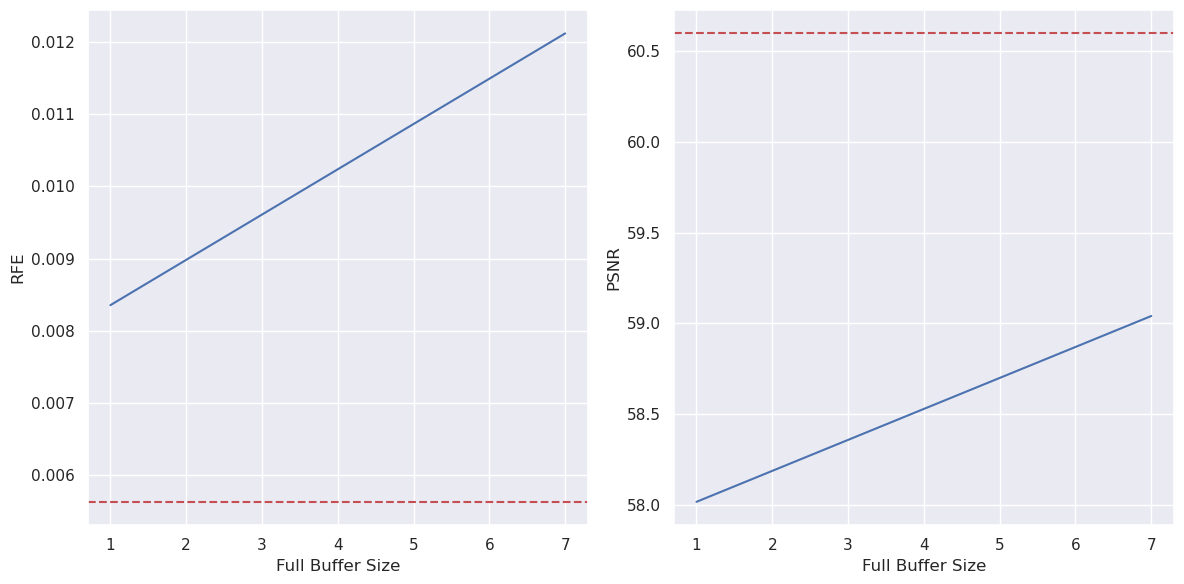

In [49]:
#Plot
fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.lineplot(data=df, x="Full Buffer Size", y="RFE", ax=ax[0])
ax[0].axhline(df_offline["RFE"][0], c="r", ls="--")

sns.lineplot(data=df, x="Full Buffer Size", y="PSNR", ax=ax[1])
ax[1].axhline(df_offline["PSNR"][0], c="r", ls="--")

fig.tight_layout()